### Data Preprocessing

In [93]:
# STEP 1: Data Preprocessing
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import warnings 
warnings.filterwarnings("ignore") 

In [99]:
# --- Parameters ---
img_size = 64
num_classes = 30
dataset_path = r"D:\Road Signs classification dataset\DATA"

In [101]:
# --- Function to Load Images ---
def load_images_from_folder(folder_path, img_size):
    X, y = [], []
    class_dirs = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])
    for label in class_dirs:
        class_folder = os.path.join(folder_path, label)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                X.append(img)
                y.append(int(label))
    return np.array(X), np.array(y)

In [103]:
# --- Load Training Data ---
print("[INFO] Loading training images...")
X, y = load_images_from_folder(dataset_path, img_size)
print(f"[INFO] Loaded {len(X)} images.")

[INFO] Loading training images...
[INFO] Loaded 743 images.


In [104]:
# --- Normalize Images ---
X = X.astype("float32") / 255.0

In [105]:
# --- Visualize Samples from Training Set ---
def visualize_samples(X, y, samples_per_class=5):
    y_labels = np.argmax(y, axis=1)
    num_classes = len(np.unique(y_labels))
    plt.figure(figsize=(samples_per_class * 2, num_classes * 2))

    for class_id in range(num_classes):
        class_indices = np.where(y_labels == class_id)[0]
        selected_indices = np.random.choice(class_indices, min(samples_per_class, len(class_indices)), replace=False)

        for i, idx in enumerate(selected_indices):
            plt_idx = class_id * samples_per_class + i + 1
            plt.subplot(num_classes, samples_per_class, plt_idx)
            plt.imshow(X[idx])
            plt.axis('off')
            plt.title(f"Class {class_id}", fontsize=8)

    plt.tight_layout()
    plt.show()

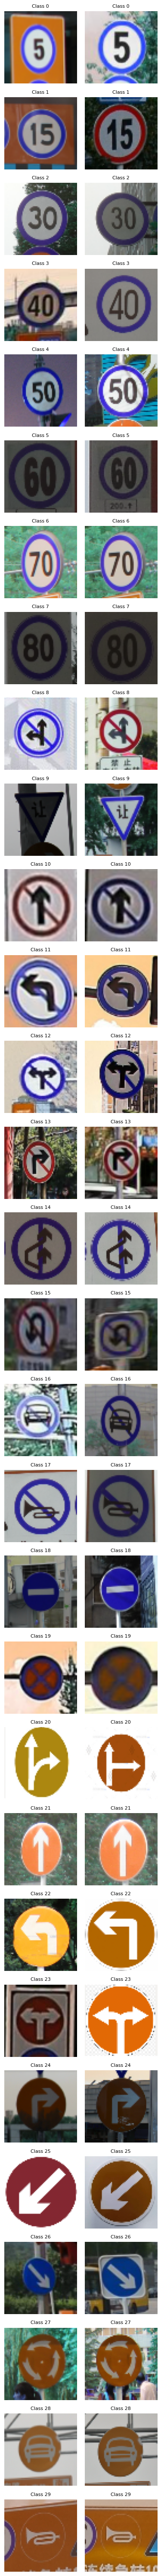

In [115]:
# --- Call Visualization ---
visualize_samples(X_train, y_train, samples_per_class=2)

In [ ]:
class_names = [f"Class {i}" for i in range(30)] 

### CNN Model

In [109]:
#Keras-sequential model - to build cnn layer by layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting

    # Output Layer (30 classes)
    Dense(30, activation='softmax')
])

In [110]:
# Get the model to learn by choosing  how it should learn
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [111]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,629,022 (6.21 MB)

 Trainable params: 1,629,022 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
# --- Convert Labels to Categorical (One-Hot) ---
y_image = to_categorical(y, num_classes=num_classes)

In [113]:
# --- Split into Training and Validation Sets ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y_image, test_size=0.15, random_state=42, stratify=y
)

In [114]:
print(f"[INFO] Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

[INFO] Training samples: 631, Validation samples: 112


In [127]:
# Predict class indices from model
y_train_preds = np.argmax(model.predict(X_train), axis=1)

# Convert true labels from one-hot to class indices
y_train_true = np.argmax(y_train, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [106]:
import matplotlib.pyplot as plt

def visualize_predictions(X, y_true, y_pred, class_names=None, count=15):
    plt.figure(figsize=(15, 8))
    for i in range(count):
        idx = np.random.randint(0, len(X))
        plt.subplot(3, 5, i+1)
        plt.imshow(X[idx])
        plt.axis("off")
        true_label = class_names[y_true[idx]] if class_names else f"True: {y_true[idx]}"
        pred_label = class_names[y_pred[idx]] if class_names else f"Pred: {y_pred[idx]}"
        plt.title(f"{true_label} / {pred_label}", fontsize=9)
    plt.tight_layout()
    plt.show()

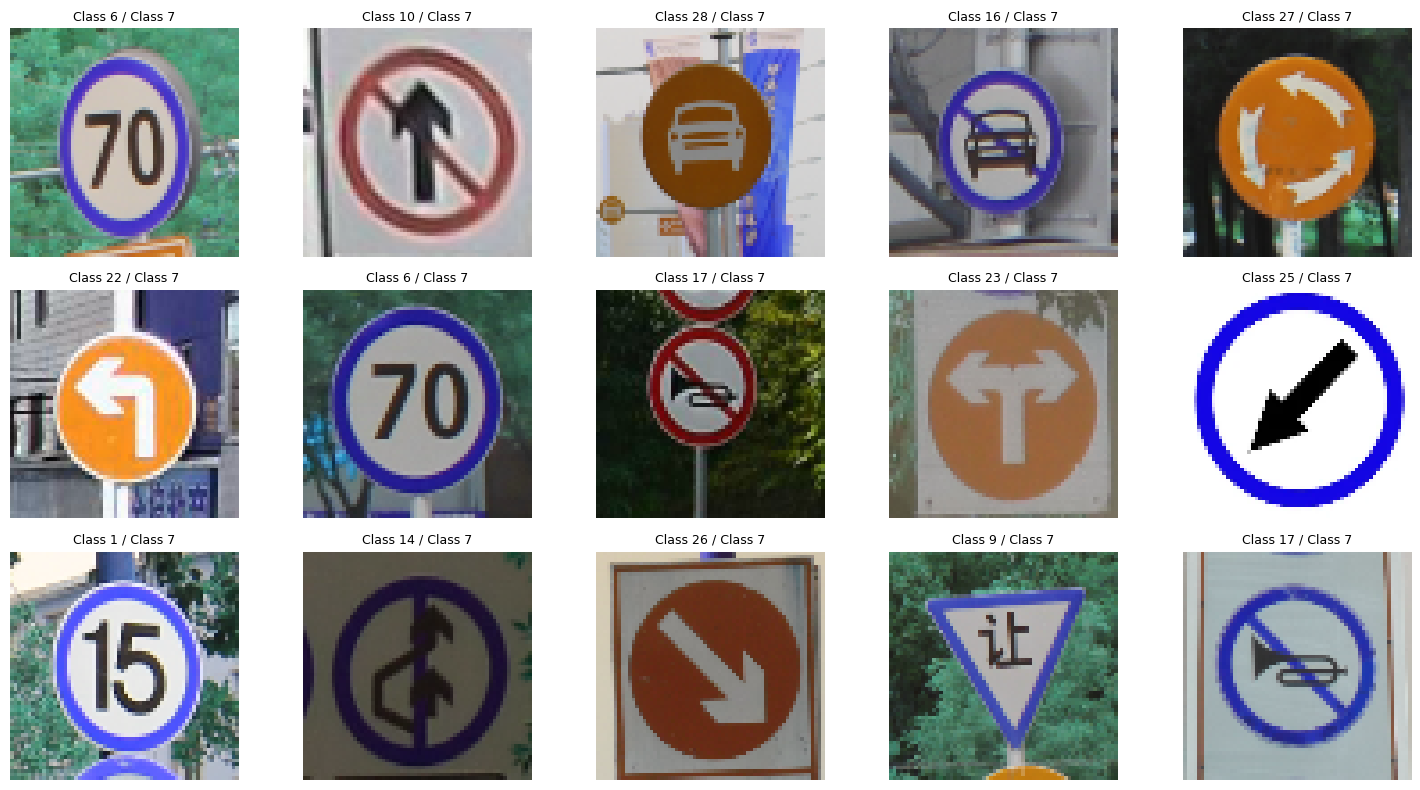

In [128]:
# Call the visualization function
visualize_predictions(X_train, y_train_true, y_train_preds, class_names)

### Training CNN 

In [131]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [133]:
# Callbacks-saves the best model,avoid overfitting by stopping at right time
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)

In [137]:
# Train the model
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0428 - loss: 3.4419

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.0440 - loss: 3.4386 - val_accuracy: 0.2321 - val_loss: 3.1686
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1816 - loss: 3.0266

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.1825 - loss: 3.0221 - val_accuracy: 0.4554 - val_loss: 2.4520
Epoch 3/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3307 - loss: 2.4985

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3349 - loss: 2.4787 - val_accuracy: 0.5893 - val_loss: 1.6948
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5843 - loss: 1.6647

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5846 - loss: 1.6622 - val_accuracy: 0.7768 - val_loss: 1.1380
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6746 - loss: 1.2224

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6755 - loss: 1.2187 - val_accuracy: 0.8750 - val_loss: 0.7705
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7417 - loss: 0.8659

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7430 - loss: 0.8641 - val_accuracy: 0.9018 - val_loss: 0.5381
Epoch 7/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8125 - loss: 0.6734

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8154 - loss: 0.6641 - val_accuracy: 0.9286 - val_loss: 0.4322
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8927 - loss: 0.4055 - val_accuracy: 0.9286 - val_loss: 0.3959
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8900 - loss: 0.3858

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8905 - loss: 0.3845 - val_accuracy: 0.9464 - val_loss: 0.3429
Epoch 10/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9464 - loss: 0.2173

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9450 - loss: 0.2204 - val_accuracy: 0.9554 - val_loss: 0.3352
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9217 - loss: 0.2880 - val_accuracy: 0.9375 - val_loss: 0.2941
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9189 - loss: 0.2786 - val_accuracy: 0.9107 - val_loss: 0.3218
Epoch 13/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9393 - loss: 0.2311 - val_accuracy: 0.9464 - val_loss: 0.3034
Epoch 14/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9513 - loss: 0.1737 - val_accuracy: 0.9375 - val_loss: 0.2837
Epoch 15/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9456 - loss: 0.1517 - val_accuracy: 0.9286 - val_loss: 0.2992
Epoch 16/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9517 - loss: 0.1669 - val_accuracy: 0.9464 - val_loss: 0.2556
Epoch 17/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9629 - loss: 0.1468 - val_accuracy: 0.9196 - val_l

In [139]:
from sklearn.metrics import classification_report

In [141]:
# Step 1: Predict class probabilities on training set
y_train_pred_probs = model.predict(X_train)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [143]:
# Step 2: Get class predictions
y_train_pred_classes = np.argmax(y_train_pred_probs, axis=1)

In [145]:
# Step 3: Convert one-hot encoded true labels back to class labels
y_train_true_classes = np.argmax(y_train, axis=1)

In [147]:
# Step 4: Generate classification report
print("Classification Report on Training Data:")
print(classification_report(y_train_true_classes, y_train_pred_classes))

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        21
           5       1.00      0.95      0.98        21
           6       1.00      1.00      1.00        21
           7       0.95      1.00      0.98        21
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        22
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        21
          14       1.00      1.00      1.00        21
          15       1.00      1.00      1.00        21
          16       1.00      1.00      1.

### Model Evaluation on Test Data

In [150]:
# Use the same function as before
X_test, y_test = load_images_from_folder(r"D:\Road Signs classification dataset\TEST",img_size)
X_test = X_test.astype("float32") / 255.0

In [152]:
from tensorflow.keras.models import load_model

# Load the best model (update the filename if you're using `.keras`)
model = load_model("best_model.h5")

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Get class predictions
y_pred_classes = np.argmax(y_pred_probs, axis=1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [154]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [156]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.67      0.33      0.44         6
           2       0.91      1.00      0.95        10
           3       1.00      0.25      0.40         4
           4       0.43      0.25      0.32        12
           5       0.50      0.05      0.09        21
           6       0.80      0.27      0.40        15
           7       1.00      0.33      0.50         3
           8       1.00      1.00      1.00         6
           9       1.00      0.12      0.22         8
          10       1.00      1.00      1.00        12
          11       0.90      0.86      0.88        22
          12       1.00      0.89      0.94         9
          13       0.34      1.00      0.51        11
          14       1.00      0.50      0.67         2
          15       0.86      0.80      0.83        15
          16       0.30      1.00      0.46        11
    

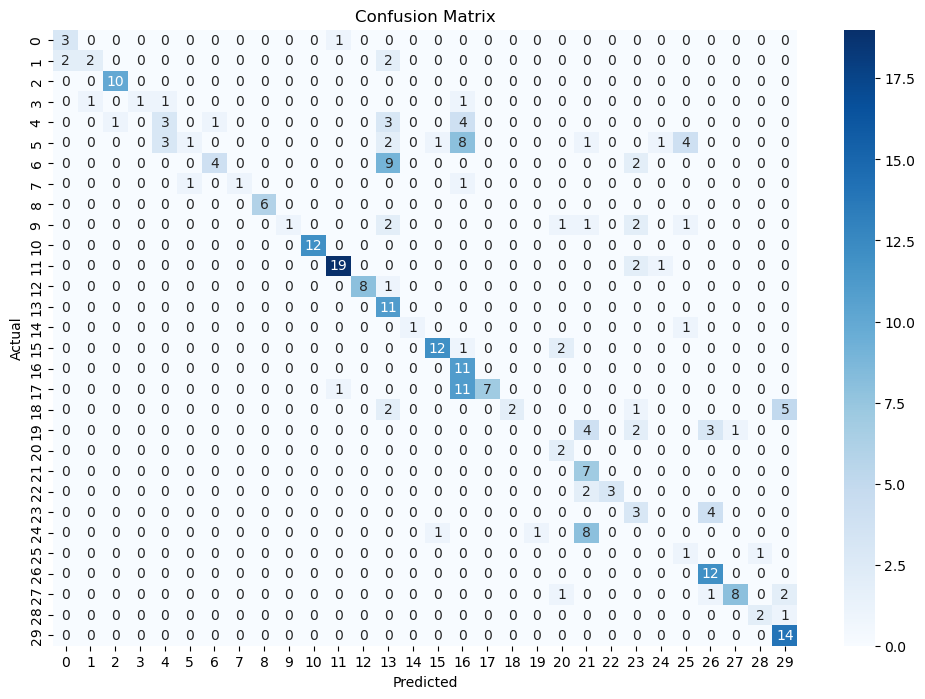

In [158]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [159]:
from sklearn.metrics import accuracy_score
print("Test Accuracy:", accuracy_score(y_test, y_pred_classes))

Test Accuracy: 0.5880281690140845


In [ ]:
# Save the best tuned model
from tensorflow.keras.models import load_model

best_model.save(r"D:\Downloads\New folder\best_tuned_model.keras")

## Streamlit

In [178]:
!pip install streamlit

In [180]:
%%writefile app.py

import streamlit as st
import numpy as np
import cv2
import pandas as pd
from PIL import Image
from tensorflow.keras.models import load_model

# --- Load class labels from CSV ---
labels_df = pd.read_csv(r"D:\Road Signs classification dataset\labels.csv")  # Make sure it's in the same directory
class_names = labels_df.set_index("ClassId")["Name"].to_dict()

# --- Load the trained model ---
model = load_model(r"D:\Downloads\New folder\best_tuned_model.keras")
img_size = 64

# --- Streamlit UI ---
st.title(" Road Sign Classifier 🚦")
st.markdown("Upload an image of a road sign to classify it into one of 30 categories.")

# --- Image Upload ---
uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png", "webp"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # --- Preprocess ---
    img = np.array(image)
    img_resized = cv2.resize(img, (img_size, img_size))
    img_normalized = img_resized.astype("float32") / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)

    # --- Predict ---
    preds = model.predict(img_batch)
    class_id = int(np.argmax(preds))
    class_name = class_names.get(class_id, f"Class {class_id}")
    confidence = np.max(preds) * 100

    # --- Display Result ---
    st.markdown("### Prediction:")
    st.success(f"{class_name} ({confidence:.2f}% confidence)")


Overwriting app.py


In [ ]:
!streamlit run app.py

### Hyper parameter tuning

In [163]:
pip install keras-tuner

In [165]:
# Define a Tuner-Compatible Mode
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(hp):
    model = Sequential()

    model.add(Conv2D(
        filters=hp.Choice('conv_1_filters', values=[32, 64, 128]),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(img_size, img_size, 3)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Choice('conv_2_filters', values=[64, 128]),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))

    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)))

    model.add(Dense(30, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [167]:
# Initialize the Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    directory='kt_logs',
    project_name='road_signs_tuning'
)

Reloading Tuner from kt_logs\road_signs_tuning\tuner0.json


In [169]:
# Run the Tuning
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=10,
    callbacks=[early_stop]
)

In [171]:
# Retrieve and Train the Best Model
# Used Keras Tuner to test different model setups
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Conv1 Filters: {best_hps.get('conv_1_filters')}")
print(f"Conv2 Filters: {best_hps.get('conv_2_filters')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")

Best Hyperparameters:
Conv1 Filters: 128
Conv2 Filters: 64
Dense Units: 256
Dropout Rate: 0.4


In [173]:
# Build and train best model
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.0340 - loss: 3.4183 - val_accuracy: 0.2321 - val_loss: 3.0521
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.2407 - loss: 2.8473 - val_accuracy: 0.6161 - val_loss: 1.9680
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.5515 - loss: 1.7918 - val_accuracy: 0.8036 - val_loss: 0.9416
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7803 - loss: 0.8571 - val_accuracy: 0.8125 - val_loss: 0.6468
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9097 - loss: 0.3727 - val_accuracy: 0.8750 - val_loss: 0.5201
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9333 - loss: 0.2696 - val_accuracy: 0.8839 - val_loss: 0.6126
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9613 - loss: 0.1590 - val_accuracy: 0.9464 - val_loss: 0.4827
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9768 - loss: 0.0842 - val_accuracy: 0.